In [ ]:
# First we need to import needed libraries
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model, load_model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from glob import glob
from keras.applications.vgg16 import VGG16
from tensorflow.python.client import device_lib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
# Setup path for dataset
train_path = r'/content/Hair Diseases - Final/train'
test_path = r'/content/Hair Diseases - Final/test'
val_path = r'/content/Hair Diseases - Final/val'

In [ ]:
IMAGE_SIZE = [224, 224]
NUM_CLASSES = 10
EPOCHS = 20

### Data agumentation and loading

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# Only rescale for testing and validation
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# Load training data with augmentation
training_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Load validation + test data without augmentation
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)
val_set = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


# Train Model

## Simple CNN Model


In [ ]:
# Initial set up for model CNN
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Create Adam optimizer with a learning rate of 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(
    loss='categorical_crossentropy',   # loss for multi-class classification
    optimizer=opt,                     # use Adam optimizer
    metrics=["acc"]                    # track accuracy during training
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

* Progressively deeper feature extraction → 32 → 64 → 128 filters

* Max pooling reduces spatial size, helps reduce computation, captures dominant features.

* Categorical output layer → suitable for 10 hair disease classes.

* Uses flatten + dense → capable of learning complex patterns.

In [ ]:
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=20,
    batch_size=128,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

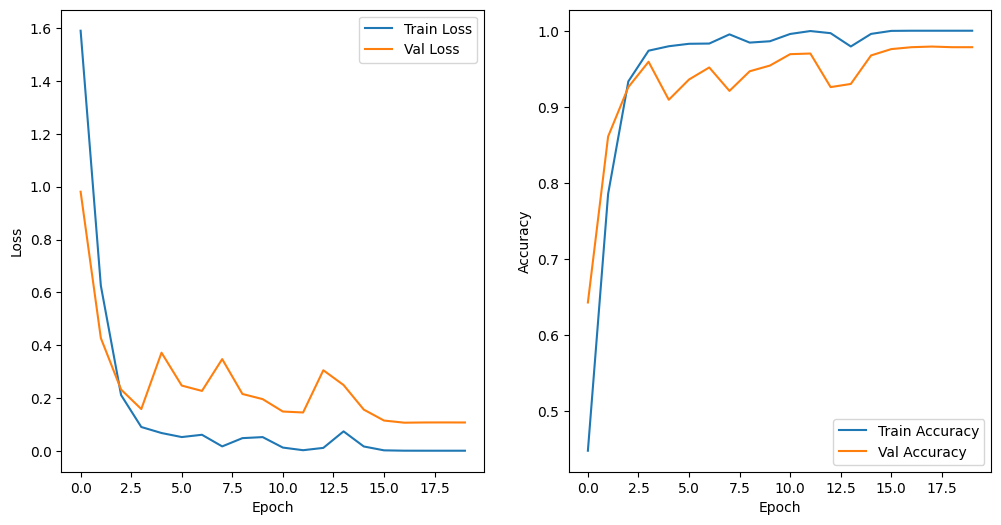

In [ ]:
# Plotting Loss & Accuracy Graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1. Train Loss / Accuracy

* Train loss (blue): Steadily decreases, very low by the end (~0 or near 0).

* Train accuracy (blue): Almost perfect (~1.0 or 100%) after a few epochs.

2. Val Loss / Accuracy

* Val loss (orange): After initial drop, it fluctuates and doesn’t improve much. It remains higher than train loss and shows some instability.

* Val accuracy (orange): Improves early, then plateaus below train accuracy (~95–97%), with small ups and downs.

### Observation
1. Possible overfitting

* Your model achieves near-perfect train accuracy but val accuracy lags behind and val loss is higher and inconsistent.

* This is a classic sign of overfitting: your model memorized the training data well but doesn’t generalize as strongly to validation data.

-> We will check on test dataset later to confirm

⚠ Val loss fluctuation

* The val loss bouncing up and down indicates that the model struggles with consistency on unseen data .



In [ ]:
model.save("train_cnn_model.h5")

In [ ]:
np.save('train_cnn_history.npy', history.history)

## VGG16


In [ ]:
rn = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()


In [ ]:
for layer in rn.layers:
    layer.trainable = False

folders = glob(train_path+'\*')

In [ ]:
x = Flatten()(rn.output)

In [ ]:
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=rn.input, outputs=prediction)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       250,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

* Proven architecture — VGG16 is well-established for image classification, good at capturing detailed texture and edge features (useful for hair/scalp images).

*  Deep feature extraction — The progressively deeper layers can capture complex patterns and subtle differences between diseases.

*  Good spatial reduction — Max pooling reduces image dimensions at each stage, avoiding massive memory use until the dense layer.

*  Final Dense(10) — Correct for your 10-class hair disease problem.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["acc"]
)

In [ ]:
annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG16.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')

In [ ]:
history = model.fit(
                  training_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(test_set)
                )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - acc: 0.4102 - loss: 1.8160
Epoch 1: saving model to /temp/1_VGG16.h5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - acc: 0.4111 - loss: 1.8130 - val_acc: 0.8525 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - acc: 0.7692 - loss: 0.7532
Epoch 2: saving model to /temp/2_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - acc: 0.7693 - loss: 0.7529 - val_acc: 0.9008 - val_loss: 0.3915 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - acc: 0.8316 - loss: 0.5551
Epoch 3: saving model to /temp/3_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.8316 - loss: 0.5549 - val_acc: 0.9483 - val_loss: 0.2387 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - acc: 0.8687 - loss: 0.4427
Epoch 4: saving model to /temp/4_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.8687 - loss: 0.4426 - val_acc: 0.9608 - val_loss: 0.1854 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - acc: 0.8865 - loss: 0.3786
Epoch 5: saving model to /temp/5_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - acc: 0.8866 - loss: 0.3785 - val_acc: 0.9467 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - acc: 0.9034 - loss: 0.3329
Epoch 6: saving model to /temp/6_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.9034 - loss: 0.3329 - val_acc: 0.9617 - val_loss: 0.1559 - learning_rate: 0.0010
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - acc: 0.9061 - loss: 0.3131
Epoch 7: saving model to /temp/7_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - acc: 0.9061 - loss: 0.3130 - val_acc: 0.9717 - val_loss: 0.1168 - learning_rate: 0.0010
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - acc: 0.9237 - loss: 0.2706
Epoch 8: saving model to /temp/8_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - acc: 0.9237 - loss: 0.2705 - val_acc: 0.9800 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.9281 - loss: 0.2468
Epoch 9: saving model to /temp/9_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.9281 - loss: 0.2468 - val_acc: 0.9767 - val_loss: 0.0947 - learning_rate: 0.0010
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - acc: 0.9341 - loss: 0.2266
Epoch 10: saving model to /temp/10_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.9341 - loss: 0.2267 - val_acc: 0.9817 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - acc: 0.9391 - loss: 0.2132
Epoch 11: saving model to /temp/11_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - acc: 0.9390 - loss: 0.2132 - val_acc: 0.9883 - val_loss: 0.0652 - learning_rate: 0.0010
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - acc: 0.9357 - loss: 0.2026
Epoch 12: saving model to /temp/12_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - acc: 0.9357 - loss: 0.2026 - val_acc: 0.9817 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.9434 - loss: 0.1955
Epoch 13: saving model to /temp/13_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.9434 - loss: 0.1955 - val_acc: 0.9725 - val_loss: 0.0912 - learning_rate: 0.0010
Epoch 14/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - acc: 0.9492 - loss: 0.1741
Epoch 14: saving model to /temp/14_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - acc: 0.9491 - loss: 0.1741 - val_acc: 0.9775 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 15/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - acc: 0.9461 - loss: 0.1775
Epoch 15: saving model to /temp/15_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - acc: 0.9461 - loss: 0.1776 - val_acc: 0.9792 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 16/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - acc: 0.9502 - loss: 0.1682
Epoch 16: saving model to /temp/16_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.9502 - loss: 0.1681 - val_acc: 0.9808 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 17/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - acc: 0.9495 - loss: 0.1625
Epoch 17: saving model to /temp/17_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - acc: 0.9495 - loss: 0.1625 - val_acc: 0.9842 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 18/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9508 - loss: 0.1639
Epoch 18: saving model to /temp/18_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - acc: 0.9508 - loss: 0.1639 - val_acc: 0.9742 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 19/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.9496 - loss: 0.1558
Epoch 19: saving model to /temp/19_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - acc: 0.9496 - loss: 0.1559 - val_acc: 0.9892 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 20/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - acc: 0.9565 - loss: 0.1416
Epoch 20: saving model to /temp/20_VGG16.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - acc: 0.9565 - loss: 0.1417 - val_acc: 0.9925 - val_loss: 0.0394 - learning_rate: 0.0010


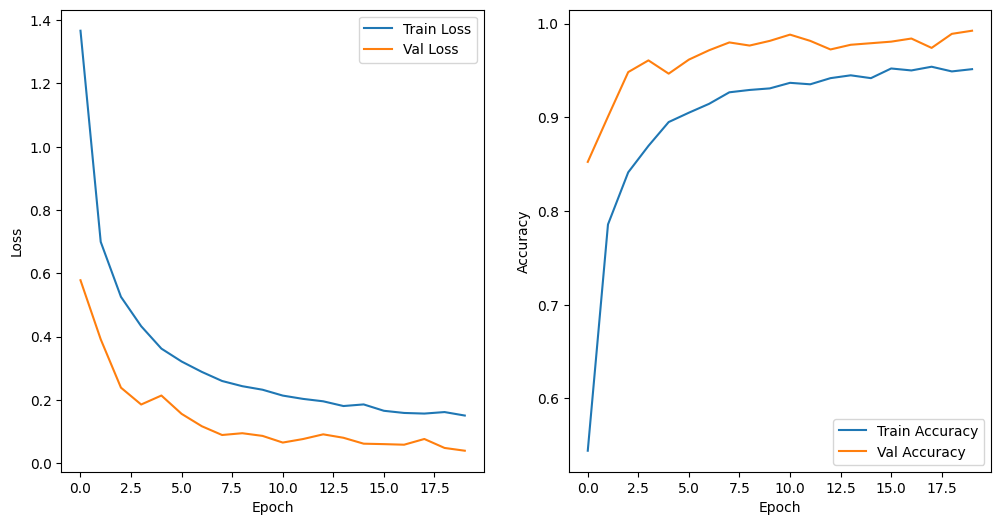

In [ ]:
# Plotting Loss & Accuracy Graphs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1. Left graph (Loss)

* Both train loss (blue) and val loss (orange) decrease steadily across epochs.

* Val loss is consistently lower than train loss.

2. Right graph (Accuracy)

* Both train and val accuracy improve over time.

* Val accuracy starts high and reaches close to 1.0 (100%) — higher than train accuracy throughout.

### Observation

1. No sign of overfitting

* Typically, overfitting would show train loss going down while val loss rises — but here, both decrease together.

* Val accuracy remains higher than train accuracy → this is unusual and suggests val data may be easier or not representative.

2. Val accuracy very high early

* Val accuracy starts at ~0.9 (90%) and rapidly approaches 1.0 — this could indicate:

* The validation set is too easy.

* Potential data leakage (val samples seen during training or too similar to train data).

* The model generalizes unusually well (but this is rare without a huge dataset).

3. Training curve looks normal

* Train loss and accuracy show expected learning behavior: smooth loss decrease and accuracy increase.

In [ ]:
model.save("train_vgg16_model.h5")

In [ ]:
np.save('train_vgg16_history.npy', history.history)

# Test VGG16 and CNN


In [ ]:
# Load the model
model_CNN = load_model("/content/drive/MyDrive/Deep/train_cnn_model.h5")
model_VGG = load_model("/content/drive/MyDrive/Deep/train_vgg16_model.h5")

In [ ]:
eval_result_cnn = model_CNN.evaluate(test_set)
test_loss_cnn, test_acc_cnn = eval_result_cnn[0], eval_result_cnn[1]
print("Test best version of model CNN on test dataset")
print(f'Test Accuracy: {test_acc_cnn * 100:.2f}%')
print(f'Test Loss: {test_loss_cnn:.4f}')

eval_result_vgg16 = model_VGG.evaluate(test_set)
test_loss_vgg16, test_acc_vgg16 = eval_result_vgg16[0], eval_result_vgg16[1]
print("Test best version of model VGG16 on test dataset")
print(f'Test Accuracy: {test_acc_vgg16 * 100:.2f}%')
print(f'Test Loss: {test_loss_vgg16:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - acc: 0.9754 - loss: 0.1094
Test best version of model CNN on test dataset
Test Accuracy: 97.00%
Test Loss: 0.1380
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - acc: 0.9940 - loss: 0.0180
Test best version of model VGG16 on test dataset
Test Accuracy: 99.08%
Test Loss: 0.0274


### Observation
The result on test set show that:
1. The model CNN is not overfitting when it gets the high accuracy on test dataset.
2. The model VGG16 gets the better performance because of high structure and optimize parameter.

Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
Confusion Matrix:
[[118   0   0   0   0   0   0   0   0   2]
 [  0 116   0   1   0   1   1   0   0   1]
 [  0   0 120   0   0   0   0   0   0   0]
 [  0   0   0 119   0   0   0   0   0   1]
 [  1   1   1   1 107   0   2   1   1   5]
 [  0   0   0   0   0 119   0   0   0   1]
 [  0   0   0   0   0   0 118   0   1   1]
 [  0   0   1   0   0   0   0 118   0   1]
 [  0   0   0   0   0   0   2   0 117   1]
 [  0   0   0   0   1   0   2   2   3 112]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       120
           1       0.99      0.97      0.98       120
           2       0.98      1.00      0.99       120
           3       0.98      0.99      0.99       120
           4       0.99      0.89      0.94       120
           5       0.99      0.99      0.99       120
           6       0.94      0.98      0.96       120
           7       0.98      0.98      0.98       120
  

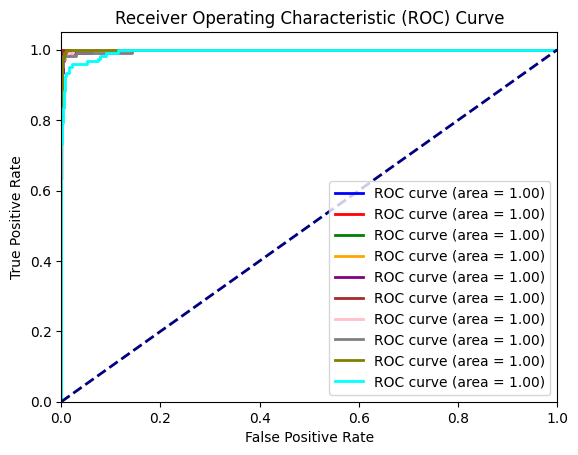

In [ ]:
history_CNN = np.load('train_cnn_history.npy', allow_pickle='TRUE').item()

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


y_true = test_set.classes
y_pred_probs = model_CNN.predict(test_set)

# If binary classification, use the first column of predictions
if y_pred_probs.shape[1] == 1:
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_pred_probs = y_pred_probs.flatten()

    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    average_precision = average_precision_score(y_true, y_pred_probs)

    # Plot precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

else:
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("Classification Report:")
    print(classification_report(y_true, y_pred))


    num_classes = len(np.unique(y_true))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

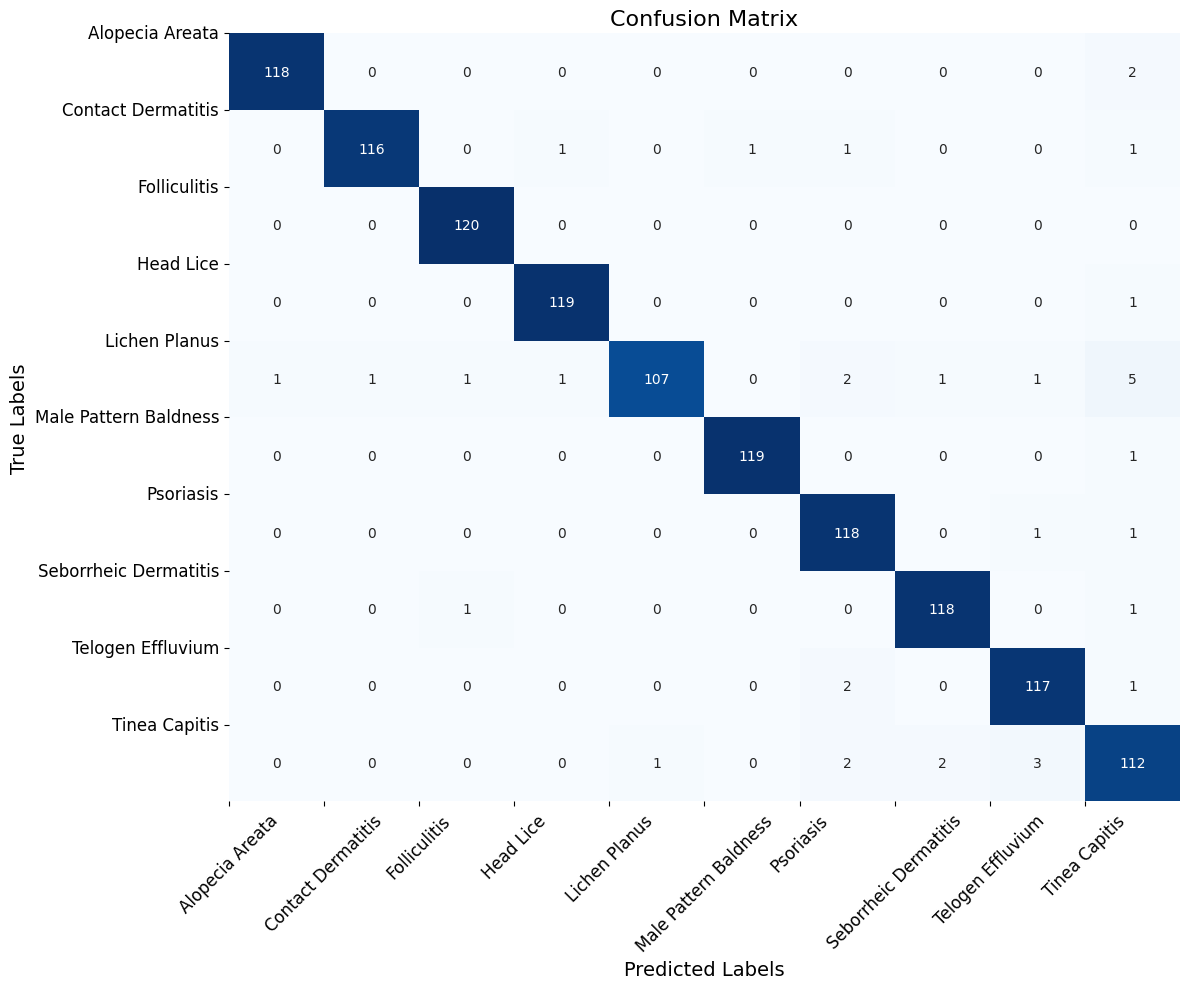

In [ ]:

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(ticks=np.arange(len(test_set.class_indices)), labels=test_set.class_indices.keys(), fontsize=12, rotation=45)
plt.yticks(ticks=np.arange(len(test_set.class_indices)), labels=test_set.class_indices.keys(), fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step
Confusion Matrix:
[[120   0   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   1   1   1   0]
 [  0   0 120   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0]
 [  0   0   0   0   0 120   0   0   0   0]
 [  0   0   0   0   0   0 119   1   0   0]
 [  0   0   0   0   0   0   1 119   0   0]
 [  0   0   0   0   0   0   0   0 120   0]
 [  0   0   0   0   1   0   2   0   3 114]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      0.97      0.99       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       0.99      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       0.97      0.99      0.98       120
           7       0.98      0.99      0.99       120


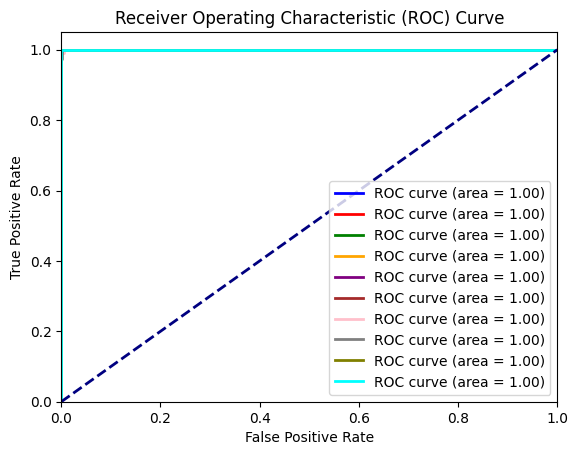

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

model = load_model("/content/train_vgg16_model.h5")
history = np.load('train_vgg16_history.npy', allow_pickle='TRUE').item()


test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


y_true = test_set.classes
y_pred_probs = model.predict(test_set)

# If binary classification, use the first column of predictions
if y_pred_probs.shape[1] == 1:
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_pred_probs = y_pred_probs.flatten()

    # Compute precision-recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    average_precision = average_precision_score(y_true, y_pred_probs)

    # Plot precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

else:
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    print("Classification Report:")
    print(classification_report(y_true, y_pred))


    num_classes = len(np.unique(y_true))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

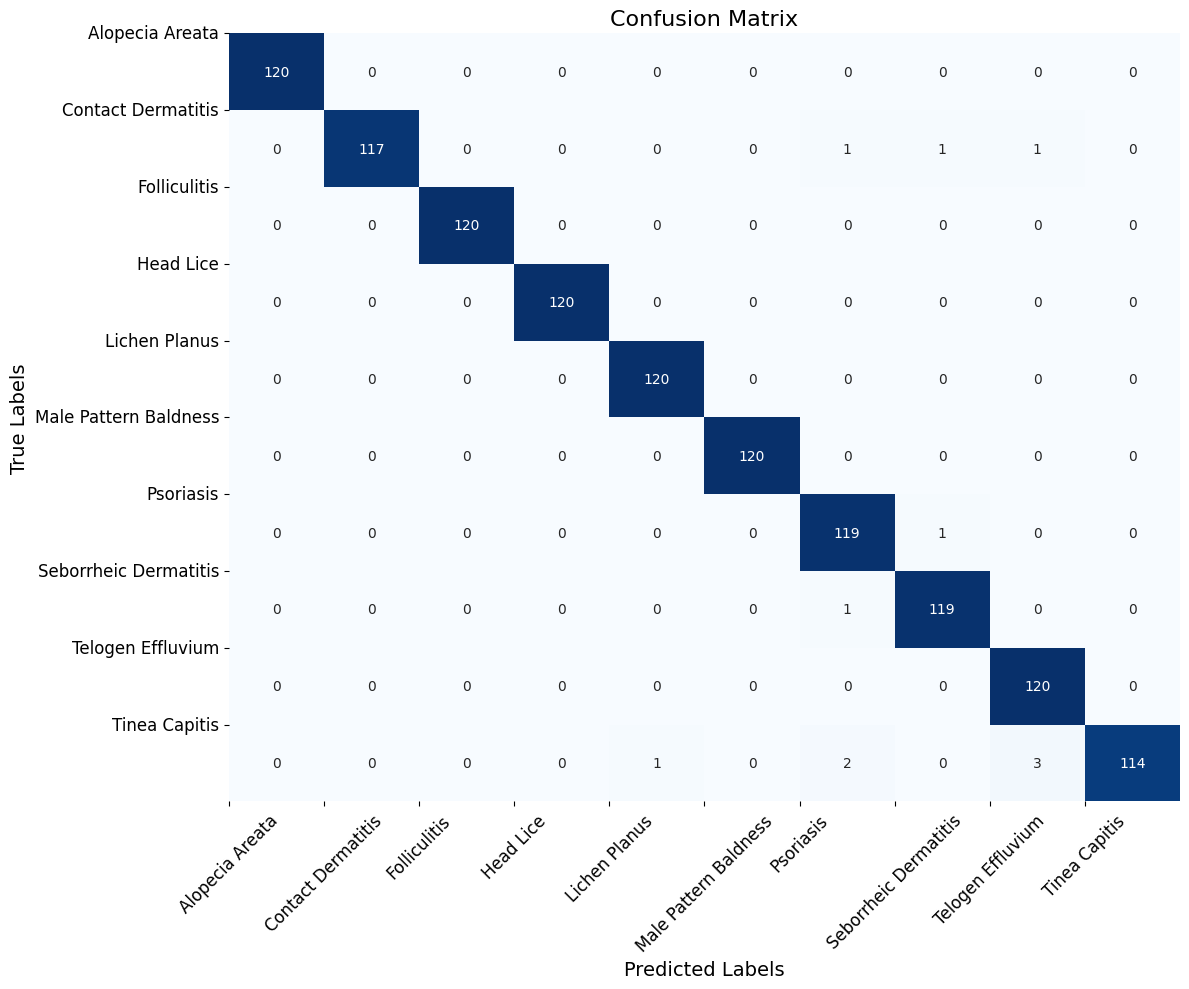

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(ticks=np.arange(len(test_set.class_indices)), labels=test_set.class_indices.keys(), fontsize=12, rotation=45)
plt.yticks(ticks=np.arange(len(test_set.class_indices)), labels=test_set.class_indices.keys(), fontsize=12, rotation=0)
plt.tight_layout()
plt.show()